# Costa Rican Household Poverty Level Prediction

In this notebook, get introduced to the problem, then perform a thorough Exploratory Data Analysis of the dataset, work on feature engineering, try out multiple machine learning models, optimize those models, inspect the outputs of the models, draw conclusions and finally select a model to predict. 

Data Explanation
The data is provided in two files: train.csv and test.csv. The training set has 9557 rows and 143 columns while the testing set has 23856 rows and 142 columns. Each row represents one individual and each column is a feature, either unique to the individual, or for the household of the individual. The training set has one additional column, Target, which represents the poverty level on a 1-4 scale and are the labels for this dataset. A value of 1 is the most extreme poverty, 2 = moderate poverty, 3 = vulnerable households and 4 = non vulnerable households

This is a supervised multi-class classification machine learning problem

Objective
The objective is to predict poverty on a household level. Moreover, we have to make a prediction for every individual in the test set, but "ONLY the heads of household are used in scoring" which means we want to predict poverty on a household basis.
While all members of a household should have the same label in the training data, there are errors where individuals in the same household have different labels. In these cases, we are told to use the label for the head of each household, which can be identified by the rows where parentesco1 == 1.0. 

Of all 143 columns, few to note are below:
idhogar: a unique identifier for each household. This variable is not a feature, but will be used to group individuals by household as all individuals in a household will have the same identifier.
parentesco1: indicates if this person is the head of the household.
Target: the label, which should be equal for all members in a household

While making the model, we'll train on a household basis with the label for each household the poverty level of the head of household. The raw data contains a mix of both household and individual characteristics and for the individual data, we will have to find a way to aggregate this for each household. Some of the individuals belong to a household with no head of household which means that unfortunately we can't use this data for training. 

Roadmap
The end objective is a machine learning model that can predict the poverty level of a household. We want to evaluate numerous models before choosing one as the "best" and after building a model, we want to investigate the predictions. The roadmap would be as follows :

1. Understand the problem 
2. Exploratory Data Analysis
3. Feature engineering to create a dataset for machine learning
4. Compare several machine learning models
5. Optimize all the models
6. Investigate model predictions in context of problem
7. Select the best model
8. Draw conclusions and lay out next steps

Getting Started

Imports - Data science libraries: Pandas, numpy, matplotlib, seaborn, and eventually sklearn for modeling.

In [100]:
# 1.1 Load pandas, numpy and matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

# Image manipulation
from skimage.io import imshow, imsave

# Image normalizing and compression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif  # Selection criteria
import eli5
from eli5.sklearn import PermutationImportance

#for data processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import  OneHotEncoder as ohe
from sklearn.preprocessing import StandardScaler as ss
from sklearn.compose import ColumnTransformer as ct
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# for modeling estimators
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier as gbm
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb

# for measuring performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
import sklearn.metrics as metrics
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

#for tuning parameters
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV
from eli5.sklearn import PermutationImportance

# Misc.
import os
import time
import gc
import random
from scipy.stats import uniform
import warnings

### Loading data and look at Summary Information

In [101]:
pd.options.display.max_columns = 150

# Read in data

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [103]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


In [104]:
ids=test['Id']

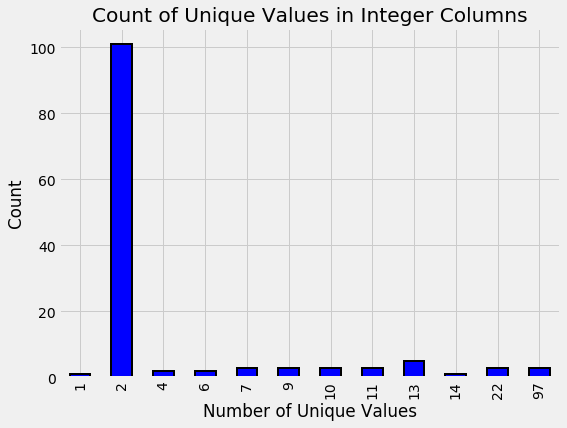

In [105]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                             figsize = (8, 6),
                                                                            edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

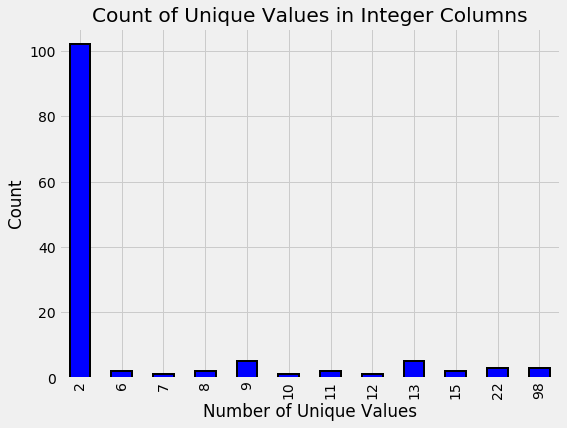

In [106]:
test.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                             figsize = (8, 6),
                                                                            edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

In [107]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


In [108]:
test.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_2f6873615,72958b30c,.5,no,17
1,ID_1c78846d2,72958b30c,.5,no,17
2,ID_e5442cf6a,72958b30c,.5,no,17
3,ID_a8db26a79,5b598fbc9,no,16,no
4,ID_a62966799,1e2fc704e,8,no,11


In [109]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


In [110]:
test[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,23856.000000,23856.000000,23856.000000
mean,1.181327,2.800176,5.199824
std,1.666209,4.603592,5.200980
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


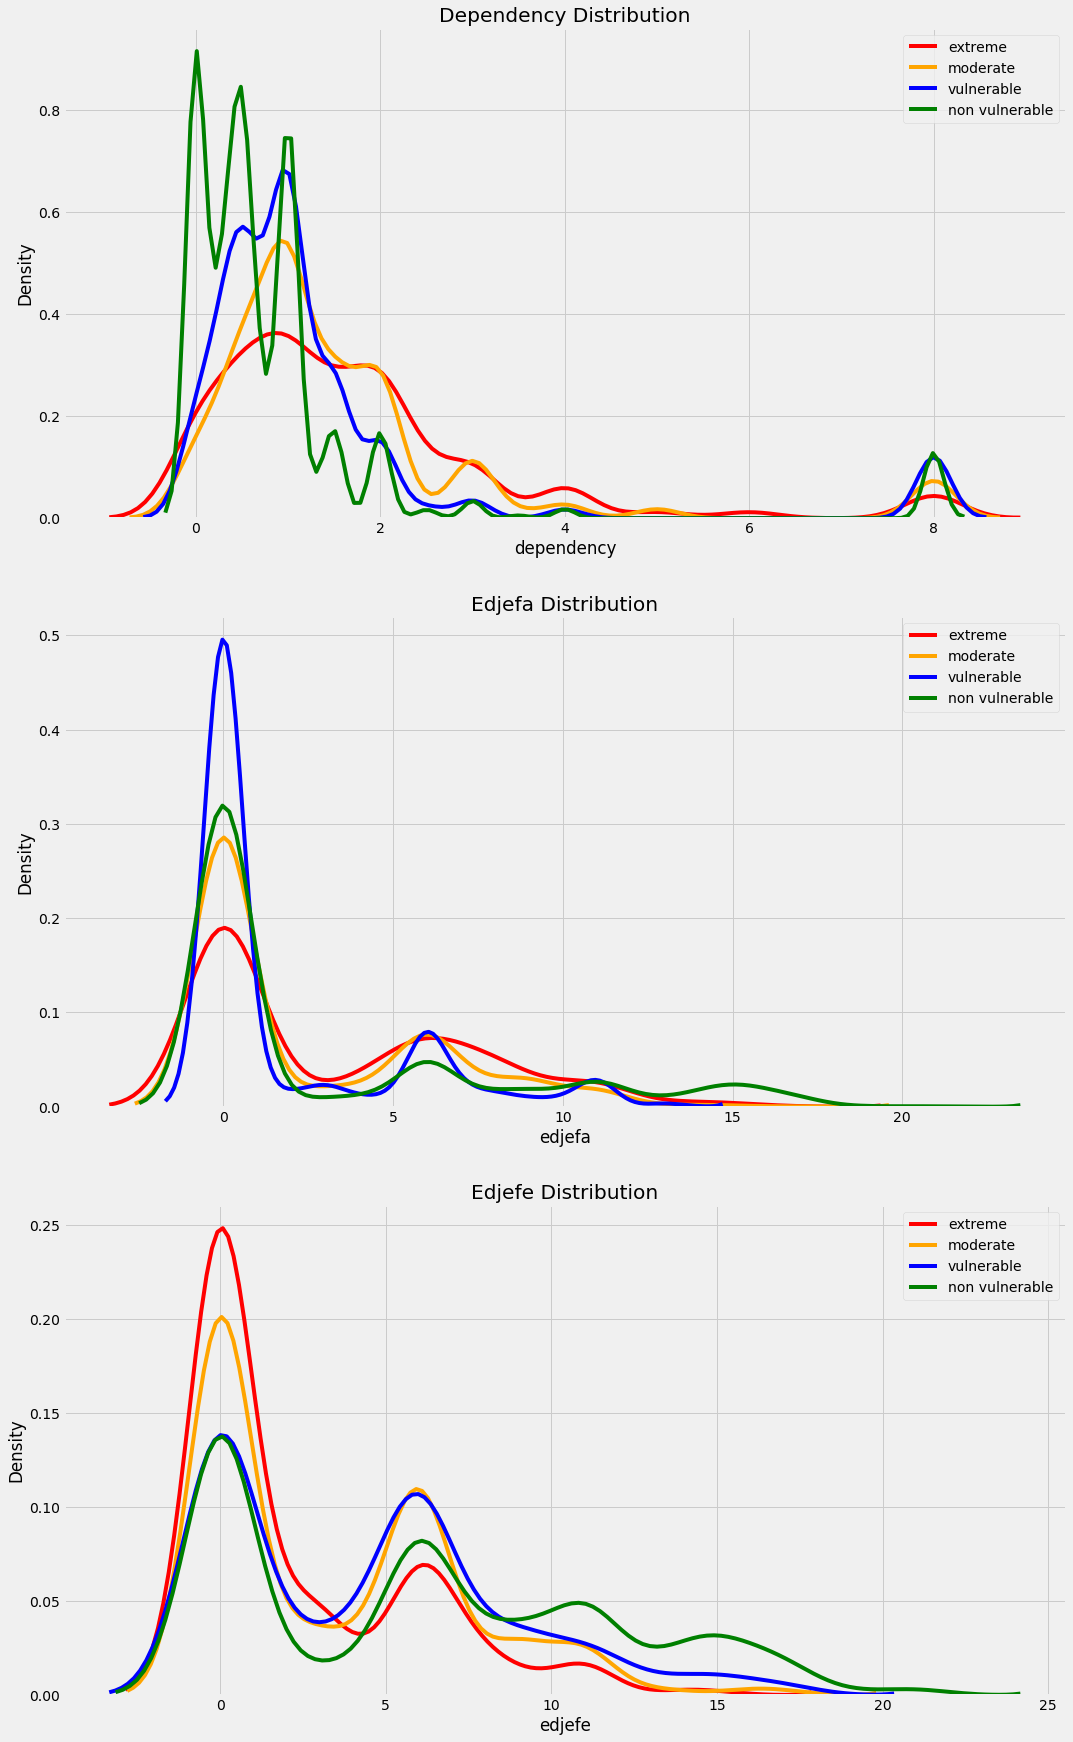

In [111]:
# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

from collections import OrderedDict

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

plt.figure(figsize = (16, 12))
plt.style.use('fivethirtyeight')

# Iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

In [112]:
test.shape

(23856, 142)

In [113]:
train.shape

(9557, 143)

In [114]:
train.shape

(9557, 143)

In [115]:
# Number of missing in each column
missing = pd.DataFrame(train.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(train)

missing.sort_values('percent', ascending = False).head(10)

,total,percent
rez_esc,7928,0.829549
v18q1,7342,0.768233
v2a1,6860,0.717798
SQBmeaned,5,0.000523
meaneduc,5,0.000523
Id,0,0.000000
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


In [116]:
# Number of missing in each column
missingte = pd.DataFrame(test.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missingte['percent'] = missingte['total'] / len(test)

missingte.sort_values('percent', ascending = False).head(10)

,total,percent
rez_esc,19653,0.823818
v18q1,18126,0.759809
v2a1,17403,0.729502
meaneduc,31,0.001299
SQBmeaned,31,0.001299
instlevel1,0,0.000000
edjefa,0,0.000000
edjefe,0,0.000000
dependency,0,0.000000
parentesco8,0,0.000000


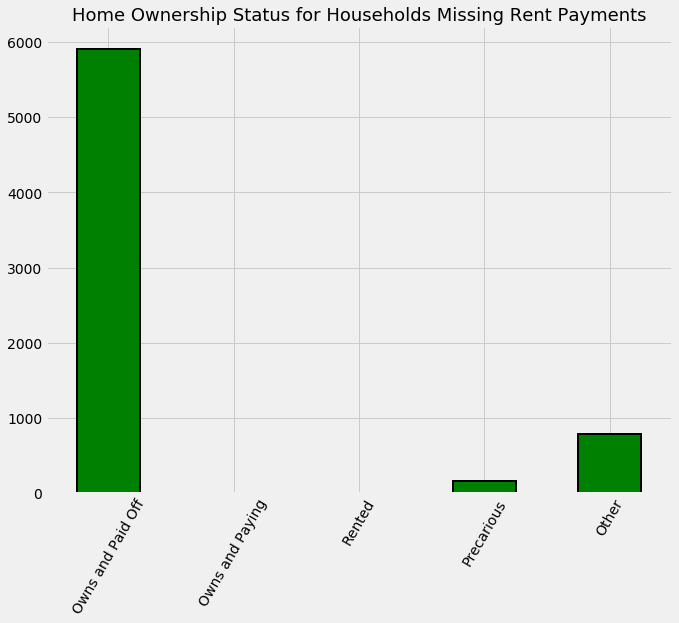

In [117]:
# Variables indicating home ownership
own_variables = [x for x in train if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
train.loc[train['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                                        color = 'green',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

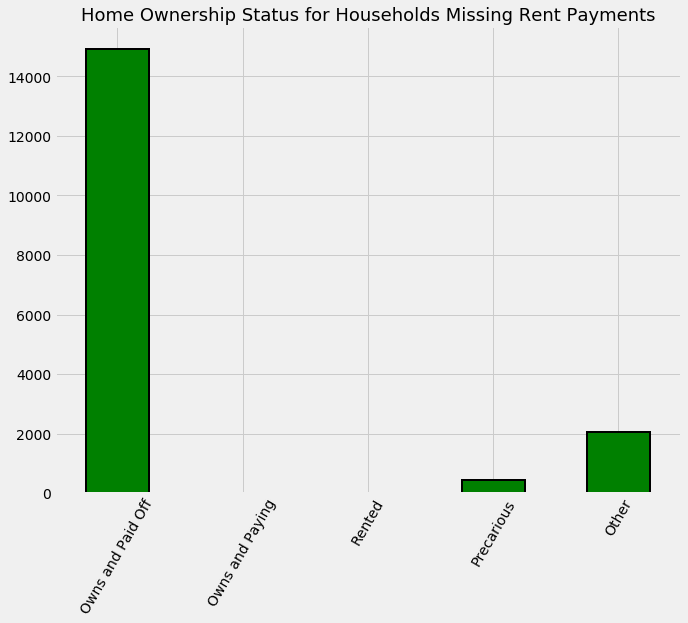

In [118]:
# Variables indicating home ownership
own_variableste = [x for x in test if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
test.loc[test['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                                        color = 'green',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

In [119]:
# Fill in households that own the house with 0 rent payment
train.loc[(train['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
train['v2a1-missing'] = train['v2a1'].isnull()

train['v2a1-missing'].value_counts()

False    8608
True      949
Name: v2a1-missing, dtype: int64

In [120]:
# Fill in households that own the house with 0 rent payment
test.loc[(test['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
test['v2a1-missing'] = test['v2a1'].isnull()

test['v2a1-missing'].value_counts()

False    21386
True      2470
Name: v2a1-missing, dtype: int64

In [121]:
train.loc[train['rez_esc'].notnull()]['age'].describe()

count    1629.000000
mean       12.258441
std         3.218325
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

In [122]:
test.loc[test['rez_esc'].isnull()]['age'].describe()

count    19653.000000
mean        39.222561
std         20.980039
min          0.000000
25%         24.000000
50%         38.000000
75%         55.000000
max         97.000000
Name: age, dtype: float64

#### Feature Engineering

Plot Two Categoricals

We draw a value count plot for where these values missing

In [123]:
train['v18q1'] = train['v18q1'].fillna(0)
test['v18q1'] = test['v18q1'].fillna(0)
train['v2a1'] = train['v2a1'].fillna(0)
test['v2a1'] = test['v2a1'].fillna(0)
train['rez_esc'] = train['rez_esc'].fillna(0)
test['rez_esc'] = test['rez_esc'].fillna(0)
train['SQBmeaned'] = train['SQBmeaned'].fillna(0)
test['SQBmeaned'] = test['SQBmeaned'].fillna(0)
train['meaneduc'] = train['meaneduc'].fillna(0)
test['meaneduc'] = test['meaneduc'].fillna(0)

In [124]:
train.shape

(9557, 144)

### Dropping unnecesary columns

In [125]:
train.drop(['Id','idhogar','v2a1-missing'], inplace = True, axis =1)

test.drop(['Id','idhogar','v2a1-missing'], inplace = True, axis =1)

In [126]:
train.shape

(9557, 141)

In [127]:
test.shape

(23856, 140)

### Dividing the data into predictors & target

In [128]:
y = train.iloc[:,140]
y.unique()

array([4, 2, 3, 1])

In [129]:
X = train.iloc[:,1:141]
X.shape

(9557, 140)

### Scaling  numeric features & applying PCA to reduce features

In [130]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler as ss

sm_imputer = SimpleImputer()
X = sm_imputer.fit_transform(X)
scale = ss()
X = scale.fit_transform(X)
#pca = PCA(0.95)
#X = pca.fit_transform(X)

In [131]:
X.shape, y.shape,test.shape

((9557, 140), (9557,), (23856, 140))

### Splitting the data into train & test 

In [132]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y,
                                                    test_size = 0.2)

## Building Models

### 1. ExtraTreeClassifier model

In [133]:
from sklearn.ensemble import ExtraTreesClassifier

modeletf = ExtraTreesClassifier()

In [134]:
start = time.time()
modeletf = modeletf.fit(X_train, y_train)
end = time.time()
(end-start)/60

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.0025191704432169595

In [135]:
classes = modeletf.predict(X_test)

classes

array([4, 4, 2, ..., 4, 4, 4])

In [136]:
(classes == y_test).sum()/y_test.size

0.9858786610878661

In [137]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, classes, average='macro')
f1

0.9734324997426738

### Tuning using Bayesian optimisation

In [138]:
bayes_cv_tuner = BayesSearchCV(
    #  Place your estimator here with those parameter values
    #      that you DO NOT WANT TO TUNE
    ExtraTreesClassifier( ),

    # 2.12 Specify estimator parameters that you would like to change/tune
    {   'n_estimators': (100, 500),           # Specify integer-values parameters like this
        'criterion': ['gini', 'entropy'],     # Specify categorical parameters as here
        'max_depth': (4, 100),                # integer valued parameter
        'max_features' : (10,64),             # integer-valued parameter
        'min_weight_fraction_leaf' : (0,0.5, 'uniform')   # Float-valued parameter
    },

    n_iter=32,            # How many points to sample
    cv = 2            # Number of cross-validation folds
)

In [139]:
# Start optimization
bayes_cv_tuner.fit(X_train, y_train)

BayesSearchCV(cv=2, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_iter=32, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring=None,
       search_spaces={'n_estimators': (100, 500), 'criterion': ['gini', 'entropy'], 'max_depth': (4, 100), 'max_features': (10, 64), 'min_weight_fraction_leaf': (0, 0.5, 'uniform')},
       verbose=0)

In [140]:
#  Get list of best-parameters
bayes_cv_tuner.best_params_

{'criterion': 'gini',
 'max_depth': 65,
 'max_features': 29,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 282}

In [141]:
modeletfTuned=ExtraTreesClassifier(criterion="entropy",
               max_depth=100,
               max_features=64,
               min_weight_fraction_leaf=0.0,
               n_estimators=500)

In [142]:
start = time.time()
modeletfTuned = modeletfTuned.fit(X_train, y_train)
end = time.time()
(end-start)/60

0.1844917098681132

In [143]:
yetf=modeletfTuned.predict(X_test)
yetf

array([4, 4, 2, ..., 4, 4, 4])

In [144]:
yetftest=modeletfTuned.predict(test)
yetftest

array([4, 4, 4, ..., 4, 4, 4])

In [145]:
#  Get what average accuracy was acheived during cross-validation
bayes_cv_tuner.best_score_

1.0

In [146]:
#  What accuracy is available on test-data
bayes_cv_tuner.score(X_test, y_test)

1.0

### 2. GradientBoostingClassifier model

In [147]:
from sklearn.ensemble import GradientBoostingClassifier as gbm

modelgbm=gbm()

In [148]:
start = time.time()
modelgbm = modelgbm.fit(X_train, y_train)
end = time.time()
(end-start)/60

0.0799228310585022

In [149]:
classes = modelgbm.predict(X_test)

classes

array([4, 4, 2, ..., 4, 4, 4])

In [150]:
(classes == y_test).sum()/y_test.size 

1.0

In [151]:
f1 = f1_score(y_test, classes, average='macro')
f1

1.0

#### Tuning using Bayesian Optimization.

In [152]:
bayes_cv_tuner = BayesSearchCV(
    #  Place your estimator here with those parameter values
    #      that you DO NOT WANT TO TUNE
    gbm(
               # No need to tune this parameter value
      ),

    # 2.12 Specify estimator parameters that you would like to change/tune
    {
        'n_estimators': (100, 500),           # Specify integer-values parameters like this
        
        'max_depth': (4, 100),                # integer valued parameter
        'max_features' : (10,64),             # integer-valued parameter
        'min_weight_fraction_leaf' : (0,0.5, 'uniform')   # Float-valued parameter
    },

    # 2.13
    n_iter=32,            # How many points to sample
    cv = 2                # Number of cross-validation folds
)

In [153]:
# Start optimization
bayes_cv_tuner.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=2, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=True, n_iter=32, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring=None,
       search_spaces={'n_estimators': (100, 500), 'max_depth': (4, 100), 'max_features': (10, 64), 'min_weight_fraction_leaf': (0, 0.5, 'uniform')},
       verbose=0)

In [154]:
#  Get list of best-parameters
bayes_cv_tuner.best_params_

{'max_depth': 30,
 'max_features': 63,
 'min_weight_fraction_leaf': 0.031405198511949735,
 'n_estimators': 207}

In [155]:
modelgbmTuned=gbm(
               max_depth=84,
               max_features=11,
               min_weight_fraction_leaf=0.04840,
               n_estimators=489)

In [156]:
start = time.time()
modelgbmTuned = modelgbmTuned.fit(X_train, y_train)
end = time.time()
(end-start)/60

0.2639918526013692

In [157]:
ygbm=modelgbmTuned.predict(X_test)
ygbm

array([4, 4, 2, ..., 4, 4, 4])

In [158]:
ygbmtest=modelgbmTuned.predict(test)
ygbmtest

array([4, 4, 4, ..., 4, 4, 4])

In [159]:
#  Get what average accuracy was acheived during cross-validation
bayes_cv_tuner.best_score_

1.0

In [160]:
#  What accuracy is available on test-data
bayes_cv_tuner.score(X_test, y_test)

1.0

### 3. Light Gradient Booster model

In [161]:
from lightgbm import LGBMClassifier

modellgb = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.1, objective='multiclass',
                             random_state=None, silent=True, metric='None', 
                             n_jobs=4, n_estimators=5000, class_weight='balanced',
                             colsample_bytree =  0.93, min_child_samples = 95, num_leaves = 14, subsample = 0.96)

In [162]:
start = time.time()
modellgb = modellgb.fit(X_train, y_train)
end = time.time()
(end-start)/60

0.41611061493555707

In [163]:
classes = modellgb.predict(X_test)

classes

array([4, 4, 2, ..., 4, 4, 4])

In [164]:
(classes == y_test).sum()/y_test.size 

1.0

In [165]:
f1 = f1_score(y_test, classes, average='macro')
f1

1.0

#### tuning using Bayesian Optimization

In [166]:
bayes_cv_tuner = BayesSearchCV(
    #  Place your estimator here with those parameter values
    #      that you DO NOT WANT TO TUNE
    lgb.LGBMClassifier(
       n_jobs = 2         # No need to tune this parameter value
      ),

    # 2.12 Specify estimator parameters that you would like to change/tune
    {
        'n_estimators': (100, 500),           # Specify integer-values parameters like this
        'criterion': ['gini', 'entropy'],     # Specify categorical parameters as here
        'max_depth': (4, 100),                # integer valued parameter
        'max_features' : (10,64),             # integer-valued parameter
        'min_weight_fraction_leaf' : (0,0.5, 'uniform')   # Float-valued parameter
    },

    # 2.13
    n_iter=32,            # How many points to sample
    cv = 3                # Number of cross-validation folds
)

In [167]:
# Start optimization
bayes_cv_tuner.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=3, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=2, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_iter=32, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring=None,
       search_spaces={'n_estimators': (100, 500), 'criterion': ['gini', 'entropy'], 'max_depth': (4, 100), 'max_features': (10, 64), 'min_weight_fraction_leaf': (0, 0.5, 'uniform')},
       verbose=0)

In [168]:
#  Get list of best-parameters
bayes_cv_tuner.best_params_

{'criterion': 'gini',
 'max_depth': 98,
 'max_features': 25,
 'min_weight_fraction_leaf': 0.48959093453487795,
 'n_estimators': 268}

In [169]:
modellgbTuned = lgb.LGBMClassifier(criterion="gini",
               max_depth=5,
               max_features=53,
               min_weight_fraction_leaf=0.01674,
               n_estimators=499)

In [170]:
start = time.time()
modellgbTuned = modellgbTuned.fit(X_train, y_train)
end = time.time()
(end-start)/60

0.07729724248250326

In [171]:
ylgb=modellgbTuned.predict(X_test)
ylgb

array([4, 4, 2, ..., 4, 4, 4])

In [172]:
ylgbtest=modellgbTuned.predict(test)
ylgbtest

array([4, 4, 4, ..., 4, 4, 4])

In [173]:
#  Get what average accuracy was acheived during cross-validation
bayes_cv_tuner.best_score_

1.0

In [174]:
#  What accuracy is available on test-data
bayes_cv_tuner.score(X_test, y_test)

1.0

In [175]:
#  And what all sets of parameters were tried?
bayes_cv_tuner.cv_results_['params']

[{'criterion': 'gini',
  'max_depth': 98,
  'max_features': 25,
  'min_weight_fraction_leaf': 0.48959093453487795,
  'n_estimators': 268},
 {'criterion': 'gini',
  'max_depth': 80,
  'max_features': 47,
  'min_weight_fraction_leaf': 0.099436546364958,
  'n_estimators': 277},
 {'criterion': 'entropy',
  'max_depth': 25,
  'max_features': 15,
  'min_weight_fraction_leaf': 0.2288725131111361,
  'n_estimators': 404},
 {'criterion': 'gini',
  'max_depth': 16,
  'max_features': 25,
  'min_weight_fraction_leaf': 0.3262930736086944,
  'n_estimators': 485},
 {'criterion': 'entropy',
  'max_depth': 48,
  'max_features': 36,
  'min_weight_fraction_leaf': 0.27530706413825046,
  'n_estimators': 290},
 {'criterion': 'entropy',
  'max_depth': 91,
  'max_features': 11,
  'min_weight_fraction_leaf': 0.20803317216712724,
  'n_estimators': 215},
 {'criterion': 'gini',
  'max_depth': 12,
  'max_features': 19,
  'min_weight_fraction_leaf': 0.3777068123780681,
  'n_estimators': 156},
 {'criterion': 'gini',


### 4. Random Forest model

In [176]:
modelrf = rf()

In [177]:
start = time.time()
modelrf = modelrf.fit(X_train, y_train)
end = time.time()
(end-start)/60

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.0021010200182596844

In [178]:
classes = modelrf.predict(X_test)
classes

array([4, 4, 2, ..., 4, 4, 4])

In [179]:
(classes == y_test).sum()/y_test.size 

0.981694560669456

In [180]:
f1 = f1_score(y_test, classes, average='macro')
f1

0.9653906078073078

#### tuning using Bayesian Optimisation

In [181]:
bayes_cv_tuner = BayesSearchCV(
    #  Place your estimator here with those parameter values
    #      that you DO NOT WANT TO TUNE
    rf(
       n_jobs = 2         # No need to tune this parameter value
      ),

    # 2.12 Specify estimator parameters that you would like to change/tune
    {
        'n_estimators': (100, 500),           # Specify integer-values parameters like this
        'criterion': ['gini', 'entropy'],     # Specify categorical parameters as here
        'max_depth': (4, 100),                # integer valued parameter
        'max_features' : (10,64),             # integer-valued parameter
        'min_weight_fraction_leaf' : (0,0.5, 'uniform')   # Float-valued parameter
    },

    # 2.13
    n_iter=32,            # How many points to sample
    cv = 3                # Number of cross-validation folds
)

In [182]:
# Start optimization
bayes_cv_tuner.fit(X_train, y_train)

BayesSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_iter=32, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring=None,
       search_spaces={'n_estimators': (100, 500), 'criterion': ['gini', 'entropy'], 'max_depth': (4, 100), 'max_features': (10, 64), 'min_weight_fraction_leaf': (0, 0.5, 'uniform')},
       verbose=0)

In [183]:
#  Get list of best-parameters
bayes_cv_tuner.best_params_

{'criterion': 'gini',
 'max_depth': 100,
 'max_features': 64,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100}

In [184]:
modelrfTuned=rf(criterion="entropy",
               max_depth=77,
               max_features=64,
               min_weight_fraction_leaf=0.0,
               n_estimators=500)

In [185]:
start = time.time()
modelrfTuned = modelrfTuned.fit(X_train, y_train)
end = time.time()
(end-start)/60

0.17700676123301187

In [186]:
yrf=modelrfTuned.predict(X_test)
yrf

array([4, 4, 2, ..., 4, 4, 4])

In [187]:
yrftest=modelrfTuned.predict(test)
yrftest

array([4, 4, 4, ..., 4, 4, 4])

In [188]:
#  Get what average accuracy was acheived during cross-validation
bayes_cv_tuner.best_score_

1.0

In [189]:
#  What accuracy is available on test-data
bayes_cv_tuner.score(X_test, y_test)

1.0

                                              ACCURACY           f1                ACCURACY
                                with default parameters       score          with  parameters tuned with Bayesian                                                                                             Optimization 
        ExtraTreesClassifier           0.99                    0.99             1.0
        GradientBoostingClassifier     1.0                     1.0              1.0 
        LightGBM                       1.0                     1.0              1.0
        RandomForestClassifier         1.0                     1.0              1.0

## BUILDING NEW DATASETS with predicted values using 4 models

In [190]:
train1 = pd.DataFrame()

train1['yetf'] = yetf.tolist()
train1['ygbm'] = ygbm.tolist()
train1['ylgb'] = ylgb.tolist()
train1['yrf'] = yrf.tolist()

train1.head(5), train1.shape

(   yetf  ygbm  ylgb  yrf
 0     4     4     4    4
 1     4     4     4    4
 2     2     2     2    2
 3     4     4     4    4
 4     2     2     2    2, (1912, 4))

In [191]:
test1 = pd.DataFrame()

test1['yetf'] = yetftest.tolist()
test1['ygbm'] = ygbmtest.tolist()
test1['ylgb'] = ylgbtest.tolist()
test1['yrf'] = yrftest.tolist()

test1.head(5), test1.shape

(   yetf  ygbm  ylgb  yrf
 0     4     4     4    4
 1     4     4     4    4
 2     4     4     4    4
 3     4     4     4    4
 4     4     4     4    4, (23856, 4))

In [192]:
EnsembleModel=rf(criterion="entropy",
               max_depth=77,
               max_features=4,
               min_weight_fraction_leaf=0.0,
               n_estimators=500)

In [193]:
start = time.time()
EnsembleModel = EnsembleModel.fit(train1, y_test)
end = time.time()
(end-start)/60

0.009290711085001627

In [194]:
ypredict=EnsembleModel.predict(test1)

In [195]:
ypredict

array([4, 4, 4, ..., 4, 4, 4])

In [196]:
ygbmtest

array([4, 4, 4, ..., 4, 4, 4])

In [197]:
submit=pd.DataFrame({'Id': ids, 'Target': ygbmtest})
submit.head(5)

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


In [198]:
submit.to_csv('submit.csv', index=False)